In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['legend.fontsize'] = 14
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 14
%matplotlib inline

# Tutorial IMU erreur model

## Creating a trajectory and generating inertial readings

First we need to generate a trajectory.

In [2]:
from pyins import sim

In [3]:
dt = 0.5
t = 3 * 3600
n_samples = int(t / dt)
lat = np.full(n_samples, 50.0)
lon = np.full(n_samples, 60.0)
alt = np.zeros_like(lat)
h = np.full(n_samples, 10.0)
r = np.full(n_samples, -5.0)
p = np.full(n_samples, 3.0)
traj, gyro_ref, accel_ref = sim.from_position(dt, lat, lon, alt, h, p, r)

In [4]:
# display of one point per min.
step_plot = int(60/dt) 

## IMU model

### gyro model

In [5]:
gyro_scale_error = None
gyro_scale_asym = None
gyro_align = None
gyro_bias = np.array([1e-8, -2e-8, 3e-8])
gyro_noise = np.array([1e-6, 1e-6, 1e-6])

### accel model

In [6]:
accel_scale_error = None
accel_scale_asym = None
accel_align = None
accel_bias = np.array([3e-3, -4e-3, 2e-3])
accel_noise = np.array([3e-4, 3e-4 , 3e-4])

In [7]:
imu = sim.ImuErrors(gyro_scale_error, gyro_scale_asym, gyro_align, gyro_bias, gyro_noise,
                    accel_scale_error, accel_scale_asym, accel_align, accel_bias, accel_noise)

Application of the error model to the reference increment

In [8]:
gyro, accel = imu.apply(dt, gyro_ref, accel_ref)

## Initial condition errors

In [9]:
d_lat = 100
d_lon = -200
d_VE = 1
d_VN = -2
d_h = 0.01
d_p = -0.02
d_r = 0.03

Adding initial errors to the trajectory

In [10]:
from pyins.coord import perturb_ll

In [11]:
lat0, lon0 = perturb_ll(traj.lat[0], traj.lon[0], d_lat, d_lon)
VE0 = traj.VE[0] + d_VE
VN0 = traj.VN[0] + d_VN
h0 = traj.h[0] + d_h
p0 = traj.p[0] + d_p
r0 = traj.r[0] + d_r

## Integration of increments

In [12]:
from pyins.integrate import coning_sculling, integrate

In [13]:
theta, dv = coning_sculling(gyro, accel)
traj_c = integrate(dt, lat0, lon0, VE0, VN0, h0, p0, r0, theta, dv)

The reference trajectory and the trajectory resulting from integration are drawn below, the initial point is marked with a cross.

Text(0, 0.5, 'lat, deg')

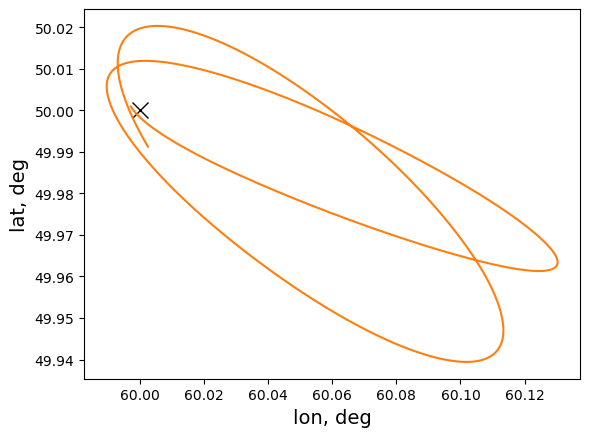

In [14]:
plt.plot(traj.lon, traj.lat)
plt.plot(traj.lon[0], traj.lat[0], 'kx', markersize=12)
plt.plot(traj_c.lon, traj_c.lat)
plt.xlabel("lon, deg")
plt.ylabel("lat, deg")

## Computing Integration Errors

In [15]:
from pyins.filt import traj_diff

In [16]:
error_true = traj_diff(traj_c, traj)

In [17]:
from helper import plot_traj

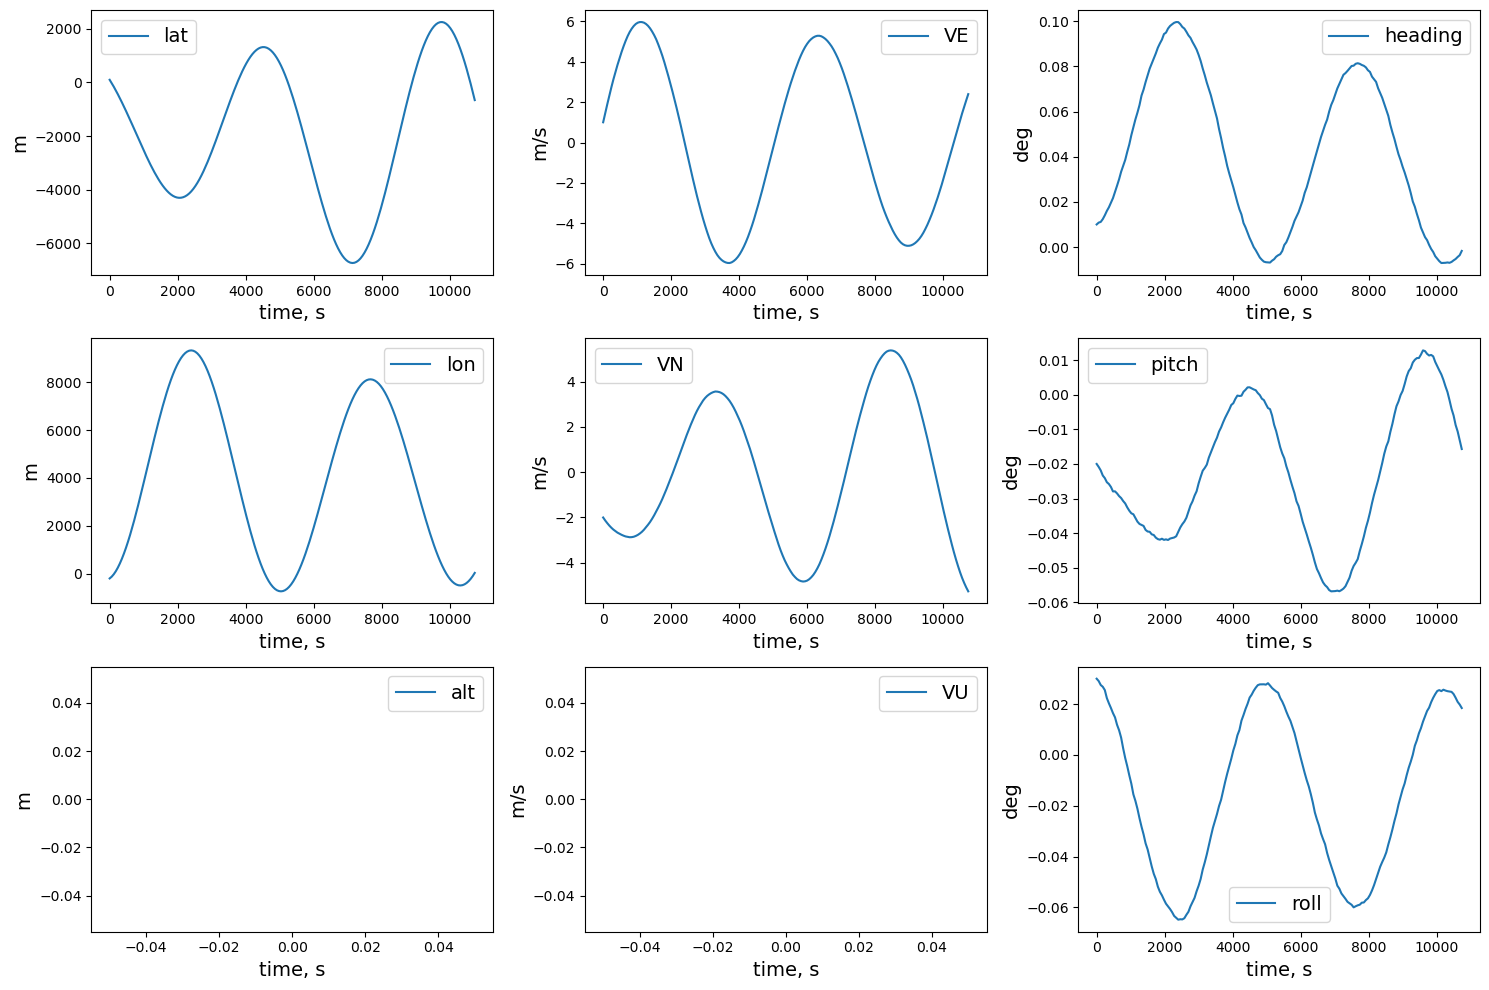

In [18]:
plot_traj(dt, error_true, step_plot, coord_unit="m")

## Propagation of IMU and initial errors

Calculation of increment errors, Gyro and accelerometer errors (in SI units) can be constant or specified for each time stamp in `traj`.

In [19]:
e_g, e_a = gyro - gyro_ref, accel - accel_ref

In [20]:
e_g = np.vstack((np.zeros(3), e_g))
e_a = np.vstack((np.zeros(3), e_a))

In [21]:
from pyins.filt import propagate_errors

In [22]:
error_linear = propagate_errors(dt, traj, d_lat, d_lon, d_VE, d_VN, d_h,
                                    d_p, d_r, e_g, e_a)

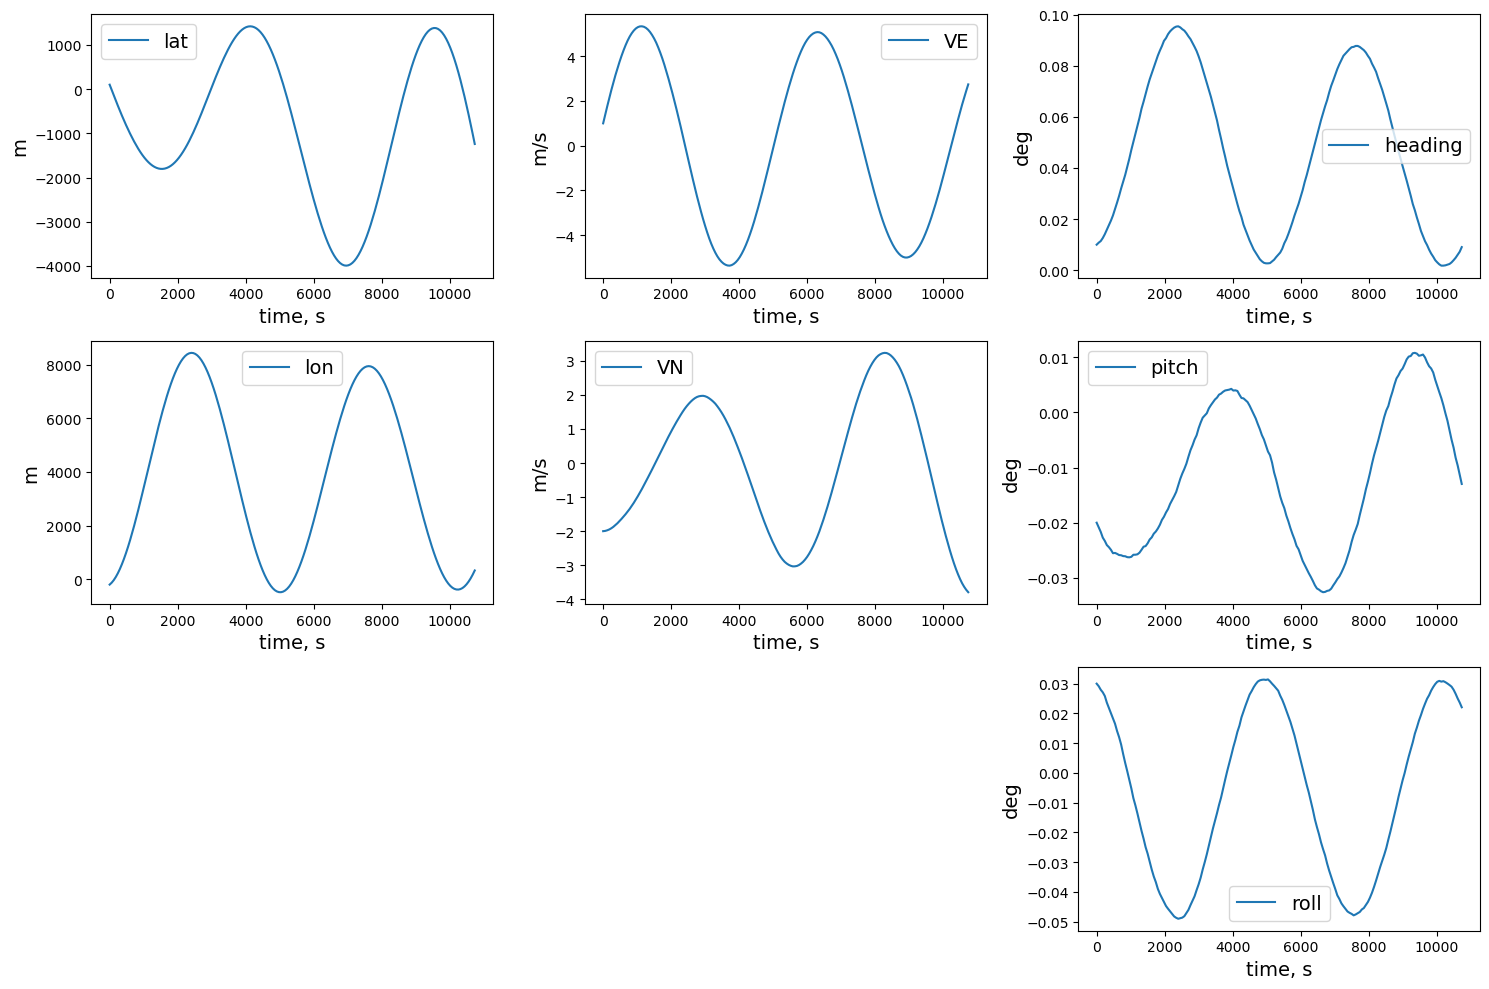

In [23]:
plot_traj(dt, error_linear, step_plot, coord_unit="m")

## Comparison of integration and propagation method

In [24]:
error_scale = np.mean(np.abs(error_true), axis=0)
rel_diff = (error_true - error_linear) / error_scale

In [25]:
rel_diff.abs().max()

VE     0.179704
VN     0.836287
VU          NaN
alt         NaN
h      0.259273
lat    1.148319
lon    0.219509
p      1.147513
r      0.539243
dtype: float64